## GA-Net

GA-Net code with Auxilliary Network  

Backbone network = BiLSTM or LSTM  
Auxiliary network = BiLSTM or LSTM  

Masked Softmax function used for implementation of Gated Attention network  

Datasets supported:
1. IMDB - Classification of movie review into positive and negative
2. TREC - Classification of question type

In [1]:
# !pip3 install torchtext==0.4
# !pip3 install dill

In [2]:
import math
import numpy as np
import pandas as pd
import pdb

import torch
import torch.nn.functional as F
import torch.distributions
import torch.optim as optim
from torch import nn 
from torch.autograd import Variable

import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

import pickle, dill, os

In [3]:
# GANet model

class GANet(torch.nn.Module):
    def __init__(self, batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, aux_hidden_size = 100, backbone_hidden_size = 100, tau = 1, biDirectional_aux = False, biDirectional_backbone = False):
        super(GANet, self).__init__() 
        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 6 = (For TREC dataset)
        hidden_sie : Size of the hidden_state of the LSTM/ BiLSTM
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 

        --------

        """
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.aux_hidden_size = aux_hidden_size
        self.backbone_hidden_size = backbone_hidden_size 
        self.mlp_out_size = mlp_out_size
        self.biDirectional_aux = biDirectional_aux
        self.biDirectional_backbone = biDirectional_backbone
        self.tau = tau

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)

        self.auxiliary = AuxiliaryNet(self.batch_size, self.aux_hidden_size, self.embedding_length, self.biDirectional_aux, tau = self.tau)
        self.backbone = BackboneNet(self.batch_size, self.backbone_hidden_size, self.embedding_length, self.biDirectional_backbone)

        if(self.biDirectional_backbone):
            self.mlp = MLP(self.backbone_hidden_size*2, self.mlp_out_size)
            self.FF = nn.Linear(self.backbone_hidden_size*2,num_classes)
        else:
            self.mlp = MLP(self.backbone_hidden_size, self.mlp_out_size)
            self.FF = nn.Linear(self.backbone_hidden_size,num_classes)
            
        self.tanh = nn.Tanh()

    def masked_Softmax(self, logits, mask):
        mask_bool = mask>0
        logits[~mask_bool] = float('-inf')
        return torch.softmax(logits, dim=1)

    
    def forward(self,input_sequence, is_train = True):
        input_ = self.word_embeddings(input_sequence)
        g_t, p_t = self.auxiliary(input_, is_train)
        out_lstm = self.backbone(input_)

        if is_train:
            e_t = self.mlp(out_lstm)
            alpha_numerator = torch.exp(e_t)*g_t
            alpha_denomenator = torch.sum(alpha_numerator, dim=1).repeat(e_t.shape[1],1,1).transpose(0,1)
            alpha = alpha_numerator/alpha_denomenator
        else:
            e_t = self.mlp(out_lstm)              
            alpha = self.masked_Softmax(e_t, g_t)
            
        c_t = torch.bmm(alpha.transpose(1,2), out_lstm)
        logits = self.FF(c_t)
        logits = self.tanh(logits)
        final_output = torch.softmax(logits, dim = -1)
        final_output = final_output.squeeze(1)

        return final_output, g_t, alpha, p_t

In [4]:
class AuxiliaryNet(torch.nn.Module):

    def __init__(self, batch_size, auxiliary_hidden_size, embedding_length, biDirectional = False, num_layers = 1, tau=1):
        super(AuxiliaryNet, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = auxiliary_hidden_size
        self.embedding_length = embedding_length
        self.biDirectional = biDirectional
        self.num_layers = num_layers

        self.aux_lstm = nn.LSTM(self.embedding_length, self.hidden_size, bidirectional = self.biDirectional, num_layers = self.num_layers, batch_first = True)   # Dropout  
        if(self.biDirectional):
            self.aux_linear = nn.Linear(self.hidden_size*2,1)
        else:
            self.aux_linear = nn.Linear(self.hidden_size,1)
        self.sigmoid = torch.nn.Sigmoid()
        self.tau = tau


    def forward(self, input_sequence, is_train = True, batch_size=None):

        # input : Dimensions (batch_size x seq_len x embedding_length)
        out_lstm, (final_hidden_state, final_cell_state) = self.aux_lstm(input_sequence) # ouput dim: (batch_size x seq_len x hidden_size) 
        out_linear = self.aux_linear(out_lstm)                                           # p_t dim: (batch_size x seq_len x 1)
        p_t = self.sigmoid(out_linear)

        if is_train:
            p_t = p_t.repeat(1,1,2)
            p_t[:,:,0] = 1 - p_t[:,:,0] 
            g_hat = F.gumbel_softmax(p_t, self.tau, hard=False)
            g_t = g_hat[:,:,1]
            g_t = g_t.reshape(g_t.shape[0], g_t.shape[1], 1)
        else:
            # size : same as p_t [ batch_size x seq_len x 1]
            m = torch.distributions.bernoulli.Bernoulli(p_t)   
            g_t = m.sample()
            
            # We do not want all the values of g_t for a sample to be 0
            # Make all g_t's 1 when all are zero
            gt_sum = g_t.sum(1)
            x = (gt_sum == 0).nonzero()
            x = x[:,0]
            for i in x:
                g_t[i,:,:] = torch.ones(g_t[i,:,:].shape)
        return g_t, p_t

In [5]:
class BackboneNet(torch.nn.Module):
    def __init__(self, batch_size, backbone_hidden_size, embedding_length, biDirectional = False, num_layers = 2):

        super(BackboneNet, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = backbone_hidden_size
        self.embedding_length = embedding_length
        self.biDirectional	= biDirectional
        self.num_layers = num_layers

        self.backbone_lstm = nn.LSTM(self.embedding_length, self.hidden_size, bidirectional = self.biDirectional, batch_first = True, num_layers = self.num_layers)   # Dropout  

    def forward(self, input_sequence, batch_size=None):
        out_lstm, (final_hidden_state, final_cell_state) = self.backbone_lstm(input_sequence)   # ouput dim: ( batch_size x seq_len x hidden_size )
        return out_lstm


In [6]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.ff_1 = nn.Linear(self.input_dim, self.output_dim)
#         self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.ff_2 = nn.Linear(self.output_dim,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out_1 = self.ff_1(x)
#         out_relu = self.relu(out_1)
        out_tanh = self.tanh(out_1)
        out_2 = self.ff_2(out_tanh)
#         out_sigmoid = self.sigmoid(out_2)

        return out_2 

In [7]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
    
def train_model(model, optim, train_iter, epoch, batch_size):
    total_epoch_loss = 0
    total_epoch_acc = 0
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not batch_size): # One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction, g_t, alpha, p_t = model(text, is_train = True)
        
        # Modifies loss function
        loss = loss_fn(prediction, target, g_t)

        # Defualt - Cross entropy loss funtion
#         loss = loss_fn(prediction, target)
        
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1
        
        # Stopping condition
        # if steps % 10 == 0:
            # print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
            # break
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    total_attention =  0
    total_samples = 0 
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]                   ### If batch size changes, change this
            if (text.size()[0] is not 32):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction, g_t, alpha, p_t = model(text, is_train = False)
            
            # For density calculation
            total_attention += torch.sum(g_t)
            total_samples += g_t.shape[0] * g_t.shape[1]
            
            # Modifies loss function
            loss = loss_fn(prediction, target, g_t)

            # Defualt - Cross entropy loss funtion
#             loss =  loss_fn(prediction, target)
            
            if math.isnan(loss.item()):
                print(prediction, target)
            
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
            
    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter), total_attention/total_samples

In [8]:
def eval_model_test(model, index, text, label):
    total_epoch_loss = 0
    total_epoch_acc = 0
    total_attention =  0
    total_samples = 0 
    model.eval()
    confusion_matrix = np.zeros((model.num_classes, model.num_classes))
    with torch.no_grad():
        for idx, text, target in zip(index, text, label):
            if (len(text) is not 32):
                continue
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction, g_t, alpha, p_t = model(text, is_train = False)

            predicted_target = prediction.argmax(1)
            for t, p in zip(target, predicted_target):
               # Rows = Actual Labels
               # Cols = Predicted Labels
                confusion_matrix[t][p] += 1

            # For density calculation
            total_attention += torch.sum(g_t)
            total_samples += g_t.shape[0] * g_t.shape[1]
            
            # Modifies loss function
            loss = loss_fn(prediction, target, g_t)

            # Defualt - Cross entropy loss funtion
#             loss =  loss_fn(prediction, target)
            
            if math.isnan(loss.item()):
                print(prediction, target)
            
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/batch_size
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
            
    return total_epoch_loss/len(index), total_epoch_acc/len(index), total_attention/total_samples, confusion_matrix

In [9]:
# data.py
def load_data(dataset, batch_size= 32, embedding_length = 100, fix_length = 200):
    # set up fields
    tokenize = lambda x: x.split()
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length= fix_length)   # change fix length from here
    # LABEL = data.LabelField()
    LABEL = data.LabelField(dtype=torch.float)

    if(dataset == 'TREC'):
      # make splits for data
      train, test = datasets.TREC.splits(TEXT, LABEL) 
    
    if(dataset == 'IMDB'):
      # make splits for data
      train, test = datasets.IMDB.splits(TEXT, LABEL)
    train, valid = train.split() 
    
    
    # build the vocabulary
    TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=embedding_length))
    LABEL.build_vocab(train)
    print(LABEL.vocab.__dict__)

    # make iterator for splits
    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
      (train, valid, test), batch_size= batch_size, device=0)

    word_embeddings = TEXT.vocab.vectors
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter

In [10]:
def loss_fn(output, target, g_t, lambda_ = 1e-4):
    T = g_t.shape[0]*g_t.shape[1]
#     loss = F.cross_entropy(output, target) + lambda_ * abs(torch.sum(g_t)/T - 2)
    loss = F.cross_entropy(output, target) + lambda_ * torch.sum(g_t)/T
    return loss

### Parameter tuning

1. Dataset:
    - IMDB  
    - TREC  
  
2. Using the parameters  
    - biDirectional_aux: If true, auxilliary network will be BiLSTM, simple LSTM otherwise
    - biDirectional_backbone: If true, backbone network will be BiLSTM, simple LSTM otherwise

In [11]:
# Over-writing the loss function to simple cross entropy loss
# loss_fn = F.cross_entropy

folder = 'models_IMDB'
sub_folder = 'BiLSTM+BiLSTM_seqLength_300_100epochs'
if not os.path.exists(folder + '/' + sub_folder):
    os.makedirs(folder + '/' + sub_folder)

learning_rate = 2e-5
batch_size = 32
output_size = 2
hidden_size = 256
embedding_length = 100
mlp_out_size = 32
aux_hidden_size = 100
batch_hidden_size = 100
tau = 1.5

num_epochs = 10
dataset = 'IMDB'
biDirectional_aux = True
biDirectional_backbone = True

if(dataset == 'IMDB'):
    num_classes = 2
    fix_length = 300
elif(dataset == 'TREC'):
    num_classes = 6
    fix_length = 10

In [12]:
TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_data(dataset, batch_size, embedding_length, fix_length)
weights = word_embeddings

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


{'freqs': Counter({'neg': 8795, 'pos': 8705}), 'itos': ['neg', 'pos'], 'unk_index': None, 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}), 'vectors': None}


In [13]:
model = GANet(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, tau=tau, biDirectional_aux = biDirectional_aux, biDirectional_backbone = biDirectional_backbone)
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

### Training


In [14]:
num_bad_epochs = 0
epoch = 0
least_loss = float('inf')
training_stats = pd.DataFrame(columns=['Epoch', 'Train_Loss', 'Train_Acc', 'Val_Loss', 'Val_Acc', 'Val_Density'])

In [15]:
while(True):
    train_loss, train_acc = train_model(model, optim, train_iter, epoch, batch_size)
    val_loss, val_acc, val_density = eval_model(model, valid_iter)
    print(f'Epoch: {epoch+1:02}')
    if val_loss < least_loss:
        least_loss = val_loss
        num_bad_epochs = 0
        print("*** Least validation loss")
        torch.save(model.state_dict(), folder + '/' + sub_folder + '/model_' + str(num_epochs) + '_best')
    else:
        num_bad_epochs += 1
    #     print(f'Epoch: {epoch+1:2}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%')
    print(f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:3f}, Val Acc: {val_acc:.2f}%, Val Density: {val_density:.4f}')
    print("-------------")

    training_stats = training_stats.append(
      pd.Series([epoch+1, train_loss, train_acc, val_loss, val_acc, val_density], index=training_stats.columns),
      ignore_index=True)
    #     if num_bad_epochs >= 10:
    #         break

    epoch += 1
    if epoch == num_epochs:
        break

torch.save(model.state_dict(), folder + '/' + sub_folder + '/model_' + str(num_epochs) + '_last')
training_stats.to_csv(folder + '/' + sub_folder + '/epochs.csv')

Epoch: 01
*** Least validation loss
Train Loss: 0.604, Train Acc: 69.05%
Val Loss: 0.531902, Val Acc: 79.24%, Val Density: 0.3229
-------------
Epoch: 02
Train Loss: 0.497, Train Acc: 84.48%
Val Loss: 0.576595, Val Acc: 73.26%, Val Density: 0.1171
-------------
Epoch: 03
*** Least validation loss
Train Loss: 0.453, Train Acc: 90.50%
Val Loss: 0.524269, Val Acc: 80.39%, Val Density: 0.9801
-------------
Epoch: 04
*** Least validation loss
Train Loss: 0.432, Train Acc: 93.33%
Val Loss: 0.500211, Val Acc: 83.70%, Val Density: 0.9843
-------------
Epoch: 05
*** Least validation loss
Train Loss: 0.420, Train Acc: 94.93%
Val Loss: 0.498856, Val Acc: 83.80%, Val Density: 0.9795
-------------
Epoch: 06
*** Least validation loss
Train Loss: 0.412, Train Acc: 95.92%
Val Loss: 0.496568, Val Acc: 84.08%, Val Density: 0.9688
-------------
Epoch: 07
Train Loss: 0.407, Train Acc: 96.58%
Val Loss: 0.497384, Val Acc: 84.19%, Val Density: 0.9673
-------------
Epoch: 08
Train Loss: 0.405, Train Acc: 96.8

In [16]:
# test_loss, test_acc, density, confusion_matrix = eval_model(model, test_iter)
# print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_ac/c:.2f}, Density: {density:.4f} ')

### Saving model parameters


In [17]:
# save parameters
para_dict = {'lr' : learning_rate, 'batch_size' : batch_size, 'embedding_length' : embedding_length, 'output_size' : output_size, 
             'hidden_size' : hidden_size, 'mlp_out_size': mlp_out_size, 'aux_hidden_size' : aux_hidden_size, 'batch_hidden_size': batch_hidden_size,
             'tau': tau, 'num_epochs' : num_epochs}
file = open(folder + '/' + sub_folder + '/parameters.txt', 'wb')
pickle.dump(para_dict, file)
file.close()

In [18]:
def save_to_pickle(dataSetObject,PATH):
    with open(PATH,'wb') as output:
        dill.dump(dataSetObject, output)
        
torch.save(weights, folder + '/' + sub_folder + '/weights')
save_to_pickle(TEXT, folder + '/' + sub_folder + '/TEXT')
index = []
text = []
label = []
for idx, batch in enumerate(test_iter):
    index.append(idx)
    text.append(batch.text[0])
    label.append(batch.label)
torch.save(index, folder + '/' + sub_folder + '/index')
torch.save(text, folder + '/' + sub_folder + '/text')
torch.save(label, folder + '/' + sub_folder + '/label')

### Testing

In [19]:
weights = torch.load(folder + '/' + sub_folder + '/weights')
index = torch.load(folder + '/' + sub_folder + '/index')
text = torch.load(folder + '/' + sub_folder + '/text')
label = torch.load(folder + '/' + sub_folder + '/label')

In [20]:
loaded_model = GANet(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, tau=tau, biDirectional_aux=biDirectional_aux, biDirectional_backbone=biDirectional_backbone)
loaded_model.load_state_dict(torch.load(folder + '/' + sub_folder + '/model_' + str(num_epochs) + '_best'))
loaded_model.eval()

GANet(
  (word_embeddings): Embedding(202054, 100)
  (auxiliary): AuxiliaryNet(
    (aux_lstm): LSTM(100, 100, batch_first=True, bidirectional=True)
    (aux_linear): Linear(in_features=200, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
  (backbone): BackboneNet(
    (backbone_lstm): LSTM(100, 100, num_layers=2, batch_first=True, bidirectional=True)
  )
  (mlp): MLP(
    (ff_1): Linear(in_features=200, out_features=32, bias=True)
    (tanh): Tanh()
    (ff_2): Linear(in_features=32, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
  (FF): Linear(in_features=200, out_features=2, bias=True)
  (tanh): Tanh()
)

In [21]:
test_loss, test_acc, density, confusion_matrix = eval_model_test(loaded_model, index, text, label)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}, Density: {density:.4f} ')
print("Confusion Matrix")
print(confusion_matrix)
precision = []
recall = []
for i in range(len(confusion_matrix)):
    precision.append(confusion_matrix[i][i]/sum(confusion_matrix[:, i]) if sum(confusion_matrix[:, i])!=0 else 1)
    recall.append(confusion_matrix[i][i]/sum(confusion_matrix[i, :]) if sum(confusion_matrix[i, :])!=0 else 1)
overall_precision = sum(precision)/len(precision)
overall_recall = sum(recall)/len(recall)
f1_score = 2*overall_precision*overall_recall/(overall_precision+overall_recall)
print("Class Precisions:")
print(precision)
print("Overall Precision: ", overall_precision)
print("Class Recalls:")
print(recall)
print("Overall Recall: ", overall_recall)
print("F1 Score: ", f1_score)
print("-------------")

Test Loss: 0.506, Test Acc: 83.34, Density: 0.9686 
Confusion Matrix
[[10302.  2197.]
 [ 1940. 10553.]]
Class Precisions:
[0.8415291619016501, 0.8276862745098039]
Overall Precision:  0.834607718205727
Class Recalls:
[0.824225938075046, 0.8447130393020091]
Overall Recall:  0.8344694886885275
F1 Score:  0.8345385977231861
-------------


In [22]:
loaded_model_last = GANet(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, tau=tau, biDirectional_aux=biDirectional_aux, biDirectional_backbone=biDirectional_backbone)
loaded_model_last.load_state_dict(torch.load(folder + '/' + sub_folder + '/model_' + str(num_epochs) + '_last'))
loaded_model_last.eval()

GANet(
  (word_embeddings): Embedding(202054, 100)
  (auxiliary): AuxiliaryNet(
    (aux_lstm): LSTM(100, 100, batch_first=True, bidirectional=True)
    (aux_linear): Linear(in_features=200, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
  (backbone): BackboneNet(
    (backbone_lstm): LSTM(100, 100, num_layers=2, batch_first=True, bidirectional=True)
  )
  (mlp): MLP(
    (ff_1): Linear(in_features=200, out_features=32, bias=True)
    (tanh): Tanh()
    (ff_2): Linear(in_features=32, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
  (FF): Linear(in_features=200, out_features=2, bias=True)
  (tanh): Tanh()
)

In [23]:
test_loss, test_acc, density, confusion_matrix = eval_model_test(loaded_model_last, index, text, label)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}, Density: {density:.4f} ')
print("Confusion Matrix")
print(confusion_matrix)
precision = []
recall = []
for i in range(len(confusion_matrix)):
    precision.append(confusion_matrix[i][i]/sum(confusion_matrix[:, i]) if sum(confusion_matrix[:, i])!=0 else 1)
    recall.append(confusion_matrix[i][i]/sum(confusion_matrix[i, :]) if sum(confusion_matrix[i, :])!=0 else 1)
overall_precision = sum(precision)/len(precision)
overall_recall = sum(recall)/len(recall)
f1_score = 2*overall_precision*overall_recall/(overall_precision+overall_recall)
print("Class Precisions:")
print(precision)
print("Overall Precision: ", overall_precision)
print("Class Recalls:")
print(recall)
print("Overall Recall: ", overall_recall)
print("F1 Score: ", f1_score)
print("-------------")

Test Loss: 0.510, Test Acc: 82.82, Density: 0.6426 
Confusion Matrix
[[11047.  1452.]
 [ 2814.  9679.]]
Class Precisions:
[0.7969843445638842, 0.8695534992363669]
Overall Precision:  0.8332689219001256
Class Recalls:
[0.8838307064565165, 0.7747538621628112]
Overall Recall:  0.8292922843096638
F1 Score:  0.8312758472960659
-------------


In [24]:
print("----- Parameters -----")
file = open(folder + '/' + sub_folder + '/parameters.txt', 'rb')
para_dict = pickle.load(file)
file.close()
print(para_dict)

----- Parameters -----
{'lr': 2e-05, 'batch_size': 32, 'embedding_length': 100, 'output_size': 2, 'hidden_size': 256, 'mlp_out_size': 32, 'aux_hidden_size': 100, 'batch_hidden_size': 100, 'tau': 1.5, 'num_epochs': 10}


In [25]:
def test_sentence(test_sen):
    test_sen_list = TEXT.preprocess(test_sen)
    print(test_sen_list)
    test_sen = [[TEXT.vocab.stoi[x] for x in test_sen_list]]
    # print(test_sen)

    test_sen = np.asarray(test_sen)
    test_sen = torch.LongTensor(test_sen)
    test_tensor = Variable(test_sen, volatile=True)

    # print(test_tensor)
    loaded_model.eval()
    prediction = loaded_model(test_tensor, is_train = False)
    print("prediction =", prediction[0])

    out_class = torch.argmax(prediction[0])
    return out_class


''' Let us now predict the sentiment on a single sentence just for the testing purpose. '''
test_sen1 = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
test_sen2 = "Ohh, such a ridiculous movie. Not gonna recommend it to anyone. Complete waste of time and money."

print('------------')
x = test_sentence(test_sen1)
print(x)
print('------------')
x = test_sentence(test_sen2)
print(x)
print('------------')

------------
['this', 'is', 'one', 'of', 'the', 'best', 'creation', 'of', 'nolan.', 'i', 'can', 'say,', "it's", 'his', 'magnum', 'opus.', 'loved', 'the', 'soundtrack', 'and', 'especially', 'those', 'creative', 'dialogues.']
prediction = tensor([[0.1192, 0.8808]], grad_fn=<SqueezeBackward1>)
tensor(1)
------------
['ohh,', 'such', 'a', 'ridiculous', 'movie.', 'not', 'gonna', 'recommend', 'it', 'to', 'anyone.', 'complete', 'waste', 'of', 'time', 'and', 'money.']
prediction = tensor([[0.8808, 0.1192]], grad_fn=<SqueezeBackward1>)
tensor(0)
------------


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


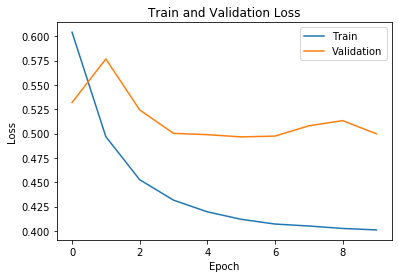

In [26]:
import matplotlib.pyplot as plt
plt.plot(training_stats['Train_Loss'], label="Train")
plt.plot(training_stats['Val_Loss'], label="Validation")
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

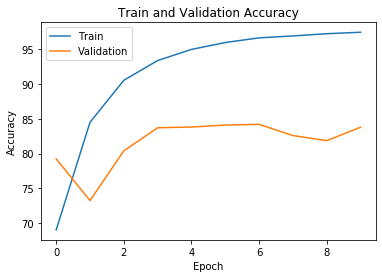

In [27]:
plt.plot(training_stats['Train_Acc'], label="Train")
plt.plot(training_stats['Val_Acc'], label="Validation")
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [28]:
# test_sen = "who is the President of India ?" 
# test_sen = "where is Rutgers University located ?"
# test_sen = "at what time does the lecture begin ?"
''' Let us now predict the sentiment on a single sentence just for the testing purpose. '''
test_sen = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
# test_sen = "Ohh, such a ridiculous movie. Not gonna recommend it to anyone. Complete waste of time and money."
# test_sen = "I admire Deepa Mehta and this movie is a masterpiece . I ’d recom- mend to buy this movie on DVD because it ’s a movie you might want to watch more often than just once . And trust me , you ’d still find little meaningful details after watching it several times. The characters - except for the grandmother perhaps - are all very bal- anced , no black and white . Even though you follow the story from the perspective of the two protagonists , there is also empathy for the other characters. I think the IMDb rating for the movie is far too low - probably due to its politically controversial content ."


test_sen_list = TEXT.preprocess(test_sen)
print(test_sen_list)
test_sen = [[TEXT.vocab.stoi[x] for x in test_sen_list]]
# print(test_sen)

test_sen = np.asarray(test_sen)
test_sen = torch.LongTensor(test_sen)
test_tensor = Variable(test_sen, volatile=True)

# print(test_tensor)
loaded_model.eval()
prediction, g_t, alpha, p_t = loaded_model(test_tensor, is_train = False)
print("prediction =", prediction)
#     print("g =", g_t)

for i in range(len(test_sen_list)):
    print(test_sen_list[i], int(g_t[0][i]), float(p_t[0][i][0]), float(alpha[0][i][0]))
out_class = torch.argmax(prediction)

['this', 'is', 'one', 'of', 'the', 'best', 'creation', 'of', 'nolan.', 'i', 'can', 'say,', "it's", 'his', 'magnum', 'opus.', 'loved', 'the', 'soundtrack', 'and', 'especially', 'those', 'creative', 'dialogues.']
prediction = tensor([[0.1192, 0.8808]], grad_fn=<SqueezeBackward1>)
this 1 0.9999545812606812 0.012370645068585873
is 1 0.9999703168869019 0.03134990483522415
one 1 0.999972939491272 0.023591479286551476
of 1 0.9999746084213257 0.038561850786209106
the 1 0.9999434947967529 0.045071687549352646
best 1 0.9999802112579346 0.05032956972718239
creation 1 0.9999780654907227 0.029235979542136192
of 1 0.9999785423278809 0.04318837821483612
nolan. 1 0.9999692440032959 0.04878738522529602
i 1 0.999970555305481 0.04954404756426811
can 1 0.9999628067016602 0.048830658197402954
say, 1 0.9999382495880127 0.049466751515865326
it's 1 0.9999468326568604 0.04993494600057602
his 1 0.999971866607666 0.04916755482554436
magnum 1 0.9999529123306274 0.04966219142079353
opus. 1 0.9999043941497803 0.049

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
